(activity15_solution)=

# Activity 15 Solution: Plotting and synthetic controls

**2025-04-22**

---

In [1]:
import linearmodels as lm
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

# Part 1: figure customization

Run the cell below to load the data. Our dataset has the following columns:

- `state`: the state name
- `year`: the year
- `retprice`: the retail price of cigarettes, covariate for building the synthetic control
- `cigsale`: cigarette sales per capita: our outcome variable
- `california`: whether the state is California (treated group)
- `after_treatment`: whether the year is after the year 1988 (when California implemented the Proposition 99 smoking tax)

In [2]:
cali_smoking = pd.read_csv('~/COMSC-341CD/data/cali_smoking.csv')

Begin by visualizing the trends in cigarette sales per capita for California and the other states by calling [sns.lineplot()](https://seaborn.pydata.org/generated/seaborn.lineplot.html) with:
-  `x='year'`
-  `y='cigsale'`
-  `hue='california'`
-  `data=cali_smoking`

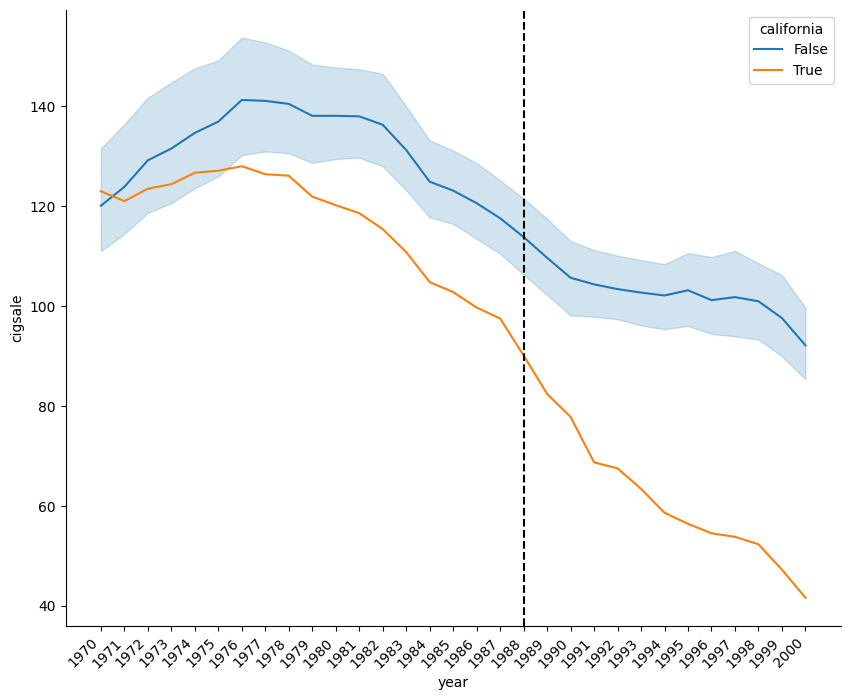

In [3]:
# Set the figure size to be 6x6 inches
fig, ax = plt.subplots(figsize=(10, 8))

# TODO plot the line plot
sns.lineplot(x='year', y='cigsale', data=cali_smoking, hue='california', ax=ax)

# Sets the x-axis ticks to be every year in the dataset
ax.set_xticks(cali_smoking['year'].unique())

# Add a vertical line at the year 1988, when Proposition 99 was implemented
ax.axvline(x=1988, color='black', linestyle='--', label='Proposition 99')

ax.set_xticklabels(labels=cali_smoking['year'].unique(), rotation=45, ha='right');
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

You'll notice that the x-axis labels are overlapping. A common solution to this is to rotate the labels so that they take up less horizontal space. You can do this by calling [ax.set_xticklabels()](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.set_xticklabels.html) with:
- `labels=cali_smoking['year'].unique()`
- `rotation=45`
- `ha='right'`, "horizontal alignment"

The xtick labels are still too crowded, so we can additionaly adjust the figure size. The current figure dimensions are set via `plt.subplots()` to be 6x6 inches, so modifying the first element in the tuple will make the figure wider.

:::{note} 

Some additional optional styling that you can explore:

- hiding the upper and right graph spines:

```python
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
```

- adding a grid:
```python
# can set the axis to be 'both', 'x', or 'y'
ax.grid(True, axis='both')
```
:::

# Part 2: merging tables

A fundamental operation in data preparation is merging tables. Let's first practice merging tables manually. 

Specifically, a **left merge** (or left join) combines two tables based on a common column (called a "key"). It keeps all rows from the left table (the first table) and adds matching information from the right table (the second table). If there's no match in the right table, the columns from the right table will show as NULL (or `np.nan` in Python) in the result.

## `customers` table

| CustomerID | Name     | City      |
|------------|----------|-----------|
| 1          | John     | Boston    |
| 2          | Sarah    | New York  |
| 3          | Mike     | Chicago   |

## `orders` table

| CustomerID | Product  | Amount |
|------------|----------|--------|
| 1          | Laptop   | 1200   |
| 4          | Keyboard | 100    |
| 2          | Monitor  | 300    |

Perform a left merge on the `CustomerID` column, where the left table is `customers` and the right table is `orders`: the rows are combined according to key column in the left table.  Again, if there's no match in the right table, the columns from the right table will show as NULL in the resulting merged table.

| CustomerID | Name     | City      | Product  | Amount |
|------------|----------|-----------|----------|--------|
| 1          | John     | Boston    | TODO     | TODO   |
| 2          | Sarah    | New York  |          |        |
| 3          | Mike     | Chicago   |          |        |

What product (if any) did Sarah order?

**Your response**: [pollev.com/tliu](https://pollev.com/tliu)

The equivalent pandas operation uses [pd.merge()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html):

```python
# perform a left merge on the `CustomerID` column
pd.merge(left=customers, right=orders, on='CustomerID', how='left')
```


:::{note}

There are other fundamental join table operations that performed in data preparation, often written in SQL:

- right join: only rows from the right table are combined
- inner join: only rows with matching keys in both tables are combined
- outer join: all rows from both tables are combined

You can see the pandas documentation of [different merge operations](https://pandas.pydata.org/docs/user_guide/merging.html#merge-types) for more deatils and a comparison to SQL.

:::

# Part 3: synthetic control

The synthetic control weights have already been computed, but need to be loaded in and merged with the California smoking data. Create the `cali_merged` dataframe by performing a **left** merge on the `state` column, where the left table is `cali_smoking` and the right table is `cali_weights`:

In [4]:
cali_weights = pd.read_csv('~/COMSC-341CD/data/cali_weights.csv')

# TODO: perform a left merge on the `state` column to merge `cali_smoking` and `cali_weights`
cali_merged = pd.merge(left=cali_smoking, right=cali_weights, on='state', how='left')

Next, select the non-california rows from the `cali_merged` dataframe and execute the following code which creates the synthetic control by computing the weighted average of the `cigsale` column:



In [5]:
# TODO: select the non-california rows from the `cali_merged` dataframe using the 'california' column
non_cali_data = cali_merged[~cali_merged["california"]]

# Creates the synthetic control by computing the weighted average of the `cigsale` outcome variable
synthetic_control = non_cali_data.groupby('year').apply(
    lambda x: np.dot(x['weight'], x['cigsale'])
).reset_index(name='synthetic_cigsale')

synthetic_control.head()

/var/folders/92/j4ms2q355sv0n3q55bgv_hwm0000gn/T/ipykernel_48688/3891592660.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  synthetic_control = non_cali_data.groupby('year').apply(


,year,synthetic_cigsale
0,1970,116.377381
1,1971,119.293413
2,1972,125.464882
3,1973,124.011265
4,1974,125.006109


Plot both california and synthetic control on the same plot using [sns.lineplot()](https://seaborn.pydata.org/generated/seaborn.lineplot.html):

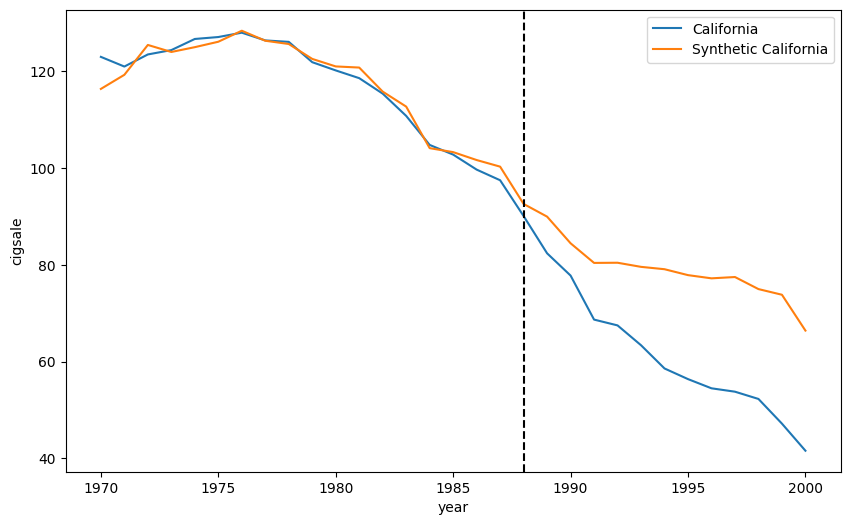

In [6]:
fig, ax = plt.subplots(figsize=(10, 6))
# TODO select the rows that correspond to California only
cali_only = cali_merged[cali_merged["california"]]

# Plot california data only with x='year', y='cigsale'
sns.lineplot(x='year', y='cigsale', data=cali_only, label='California', ax=ax)


# Plot the synthetic control data with x='year', y='synthetic_cigsale'
sns.lineplot(x='year', y='synthetic_cigsale', data=synthetic_control, label='Synthetic California', ax=ax)

ax.axvline(x=1988, color='black', linestyle='--', label='Proposition 99')

Using pandas selection based on `'year'`,  `'cigsale'`, and `'synthetic_cigsale'`, what is the difference in cigarette sales per capita between California and the synthetic control in the year 1995? 

**Your response**: [pollev.com/tliu](https://pollev.com/tliu)

In [7]:
# TODO select the cigsale column for California in 1995 using the cali_only dataframe
cali_1995_cigsale = cali_only[cali_only['year'] == 1995]['cigsale']

# TODO select the synthetic_cigsale column for the synthetic control in 1995 using the synthetic_control dataframe
synthetic_1995_cigsale = synthetic_control[synthetic_control['year'] == 1995]['synthetic_cigsale']

# Compute the difference between the extracted values
print(cali_1995_cigsale.values[0] - synthetic_1995_cigsale.values[0])


-21.490618944231052


# Acknowledgements

This activity is based off of the synthetic control chapter of Facure (2023): Causal Inference for the Brave and the True.